In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt

import corsikadata
import simple_conv_net
from tqdm import tqdm

import time

corsika_data module imported

simple_conv_net module imported



In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device = 'cpu'
print(device)

cpu


/home/ilyas/soft/TAIGA_CNN/data/mlenv/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
start = time.perf_counter()

files = ["input/taiga607_st2b", "input/taiga623_st2b"]
dataset = corsikadata.CorsikaData()

dataset.load(files)

end = time.perf_counter()
print(f"Elapsed time: {end - start:.6f} seconds")

after init data shape (0, 1, 27, 27)
after init labels shape (0,)
loading file input/taiga607_st2b

before concatenate data shape (0, 1, 27, 27)

before concatenate labels shape (0,)
after concatenate labels data (47109, 1, 27, 27) 

after concatenate labels shape (47109,) 

after goodness cut data shape (47109, 1, 27, 27)
after goodness cut labels shape (47109,)
data.dtype: float32
labels.dtype: int64 


loading file input/taiga623_st2b

before concatenate data shape (47109, 1, 27, 27)

before concatenate labels shape (47109,)
after concatenate labels data (88953, 1, 27, 27) 

after concatenate labels shape (88953,) 

after goodness cut data shape (88474, 1, 27, 27)
after goodness cut labels shape (88474,)
data.dtype: float32
labels.dtype: int64 


loading files done


Elapsed time: 8.452878 seconds


In [4]:
train_loader, test_loader = dataset.create_data_loader(batch_size=256, train_portion = 0.95, shuffle_seed = 42)

create_data_loader done


In [5]:
def evaluate_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()  # set the model to evaluation mode
    with torch.no_grad():
        for data, labels in loader:
            # Move data and labels to the model's device
            data, labels = data.to(model.device), labels.to(model.device)
            y_pred = model(data)
            y_pred = y_pred.reshape(len(labels))
            y_pred = y_pred > 0.5  # threshold predictions
            correct += (y_pred == labels).sum().item()
            total += len(labels)
    accuracy = correct / total
    return accuracy

In [6]:
def predict(model, loader):
    y_probabilities = np.array([])
    i = 0
    model.eval()  # set the model to evaluation mode
    for data, labels in loader:
        y_pred = model(data.to(device))
        tmp = y_pred.detach().cpu().numpy()
        if i == 0:
            print("tmp.shape", tmp.shape)
        y_probabilities = np.concatenate((y_probabilities, tmp.squeeze()))
        i+=1
    return y_probabilities

In [7]:
net = simple_conv_net.SimpleConvNet()
losses = []
accuracies_test = []
accuracies_train = []

CNN will run on device: cpu


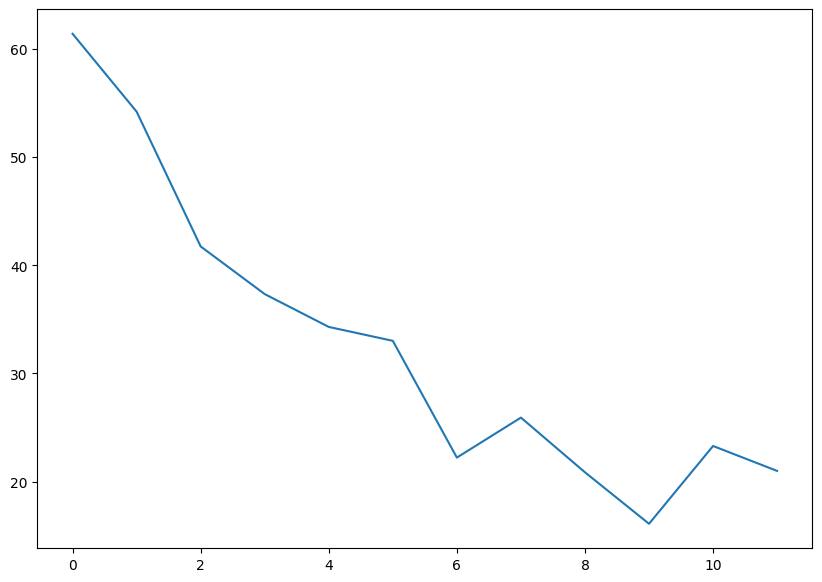

100%|██████████████████████████████████████████████████████████████████████| 4/4 [02:50<00:00, 42.65s/it]

Обучение закончено


In [8]:
from IPython.display import clear_output, display
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

epochsN = 4

for epoch in tqdm(range(epochsN)):
    running_loss = 0.0
    i = 0
    # Iterate over the single train_loader that returns (data, labels) pairs
    for data, labels in train_loader:
        net.my_optimizer.zero_grad()
        
        # Forward pass
        y_pred = net(data.to(net.device))
        y_pred = y_pred.reshape(len(labels))
        
        # Convert to float
        labels = labels.to(torch.float32)
        y_pred = y_pred.to(torch.float32)
        
        # Compute loss and backpropagate
        loss = net.my_loss_fn(y_pred, labels.to(net.device))
        loss.backward()
        net.my_optimizer.step()
        
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss))
            losses.append(running_loss)
            running_loss = 0.0
        i += 1
    # Evaluate accuracy with the updated single test_loader (which returns (data, labels))
    accuracies_test.append(evaluate_accuracy(net, test_loader))
    accuracies_train.append(evaluate_accuracy(net, train_loader))
            
    ax.clear()
    ax.plot(np.arange(len(losses)), losses)
    clear_output(wait=True)
    display(fig)
    plt.show()
print('Обучение закончено')

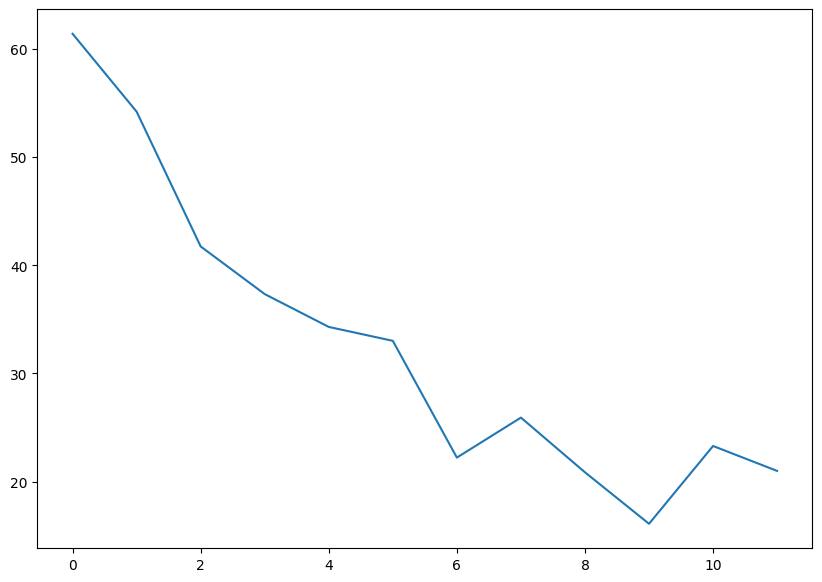

In [9]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(losses)), losses)
plt.show()


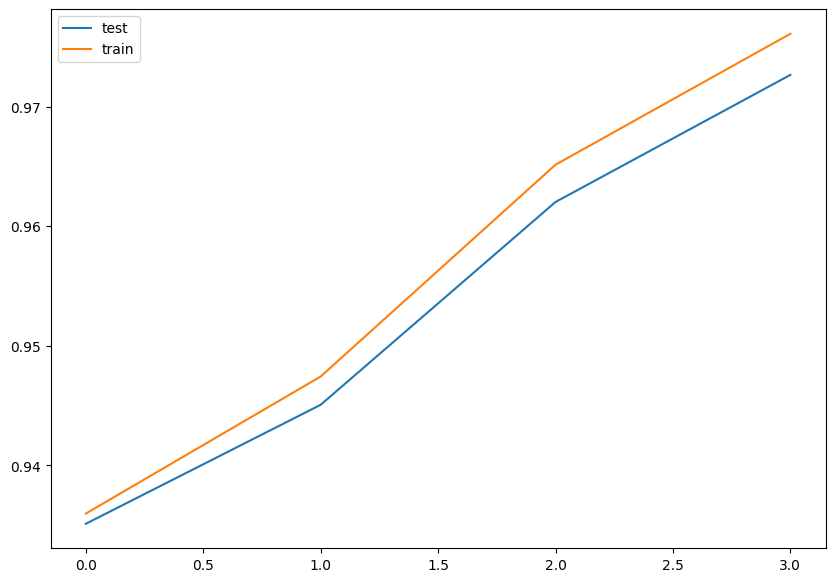

In [10]:
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(1, 1, 1)

ax.plot(np.arange(len(accuracies_test)), accuracies_test, label = 'test')
ax.plot(np.arange(len(accuracies_train)), accuracies_train, label = 'train')

plt.legend()
plt.show()

In [11]:
test_y_probabilities = predict(net, test_loader)
print(type(test_y_probabilities))
print(len(test_y_probabilities))
print(test_y_probabilities.shape)

tmp.shape (256, 1)
<class 'numpy.ndarray'>
4424
(4424,)


In [12]:
train_y_probabilities = predict(net, train_loader)
print(type(train_y_probabilities))
print(len(train_y_probabilities))
print(train_y_probabilities.shape)

tmp.shape (256, 1)
<class 'numpy.ndarray'>
84050
(84050,)


In [13]:
from metrics import Metrics
metrics = Metrics()

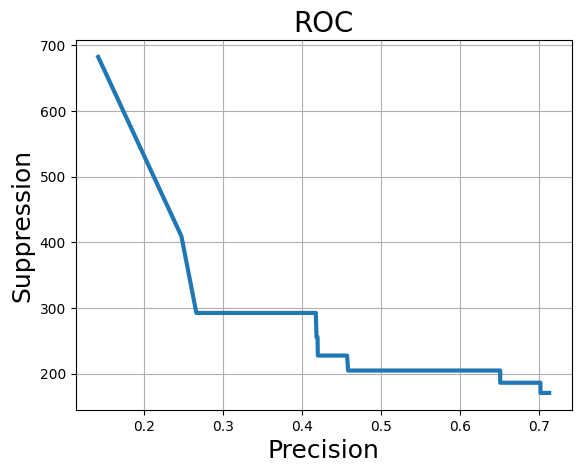

In [14]:
test_precision_array, test_suppression_array = metrics.draw_precision_from_suppression(test_y_probabilities, dataset.labels[dataset.test_indices], gate_start_value = 0.9, gate_n = 500)

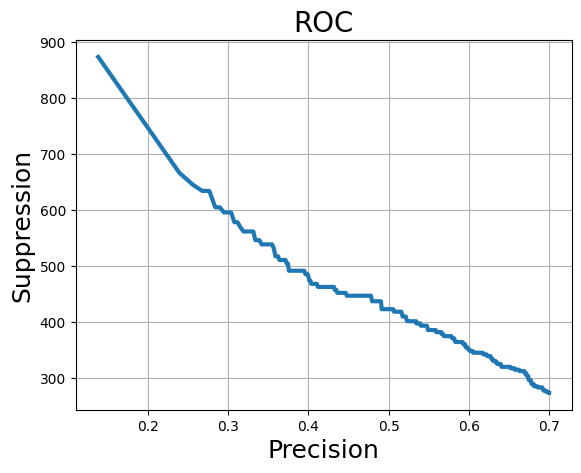

In [15]:
train_precision_array, train_suppression_array = metrics.draw_precision_from_suppression(train_y_probabilities, dataset.labels[dataset.train_indices], gate_start_value = 0.9, gate_n = 500)

In [16]:
train_suppression_array

[273.0416666666667,
 273.0416666666667,
 273.0416666666667,
 274.95104895104896,
 274.95104895104896,
 274.95104895104896,
 274.95104895104896,
 274.95104895104896,
 274.95104895104896,
 276.88732394366195,
 276.88732394366195,
 276.88732394366195,
 276.88732394366195,
 276.88732394366195,
 276.88732394366195,
 278.8510638297872,
 278.8510638297872,
 280.84285714285716,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 282.863309352518,
 284.9130434782609,
 284.9130434782609,
 284.9130434782609,
 284.9130434782609,
 284.9130434782609,
 284.9130434782609,
 284.9130434782609,
 284.9130434782609,
 289.1029411764706,
 289.1029411764706,
 289.1029411764706,
 289.1029411764706,
 289.1029411764706,
 289.1029411764706,
 293.4179104477612,
 295.62406015037595,
 295.62406015037595,
 295.62406015037595

In [17]:
def draw_regression(y_prediction, test_labels):


    y_prediction = y_prediction.reshape((-1,))
    test_labels = test_labels.reshape((-1,))

    true_lefts = y_prediction[test_labels==0]
    true_rights = y_prediction[test_labels==1]

    print("true_lefts.shape ",true_lefts.shape)
    print("true_rights.shape ",true_rights.shape)

    fig, ax = plt.subplots()

    ax.hist([true_lefts, true_rights], 100, density=False, histtype='step', stacked=False, label=['proton', 'gamma'], linewidth=3)			
    ax.legend(prop={'size': 15})
    ax.set_yscale('log')
    ax.set_title("regression outputs", fontsize=20)
    plt.grid(True, which='both')

true_lefts.shape  (2047,)
true_rights.shape  (2377,)


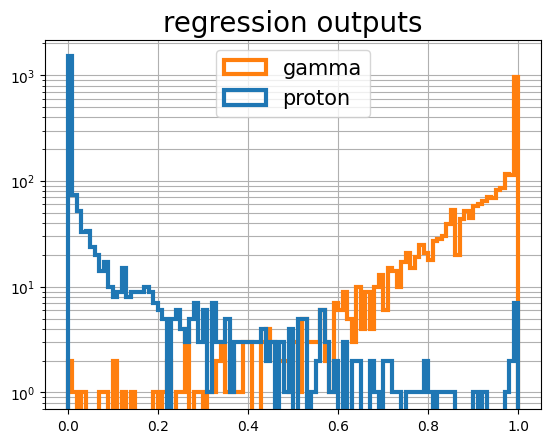

In [18]:
draw_regression(test_y_probabilities,dataset.labels[dataset.test_indices])

In [19]:
test_y_probabilities.shape

(4424,)

In [20]:
dataset.labels[dataset.test_indices].shape

(4424,)

true_lefts.shape  (39318,)
true_rights.shape  (44732,)


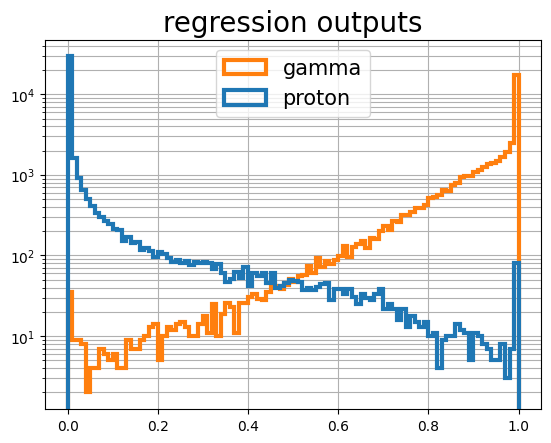

In [21]:
draw_regression(train_y_probabilities, dataset.labels[dataset.train_indices])

In [22]:
train_y_probabilities.shape

(84050,)

In [23]:
dataset.labels[dataset.train_indices].shape

(84050,)

In [24]:
evaluate_accuracy(net, test_loader)

0.9726491862567812

In [25]:
evaluate_accuracy(net, train_loader)

0.9760856632956574